# Track Pattern Recognition using Hough Transform

## Introduction

Track pattern recognition is an early step of the reconstruction of data coming from a particle detector. It recognizes tracks among the subdetectors hits. Reconstructed track parameters allow to estimate the particle deviation in a magnetic field, and thus reconstruct its charge and momentum. This information is used for the reconstruction of the decay vertex, to identify the mother particle and for further particle identification.

There is wide variety of the track pattern recognition methods. They differ in how they process the hits, what kind of tracks they are able to recognize and which requirements these tracks should satisfy. Therefore, specifics of an experiment and the detector geometry affect the tracking performance and track pattern recognition methods should be adapted to it accordingly.

In this notebook a track pattern recognition for a 2D detector with circular geometry and uniform magnetic field is considered. The detector schema with hits and tracks of an event is shown in the figure below. The challenge is to recognize tracks of an event with the highest efficiecny. It supposed that one hit can belong to only one track. 

<img src="pic/detector.png" /> <br>

## About this notebook

This notebook demonstrate how Hough Transform can be used for track pattern recognition. The notebook describes input data, the track pattern recognition method and qualyti metrics, and shows how to use them.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas
import numpy

import user_test_submission as submission

# Input data

In [2]:
data = pandas.read_csv('public_train.csv', index_col=False)
data = data[data['event_id'].values < 100]

data.head()

,event_id,cluster_id,layer,iphi,x,y
0,3,4,4,53253,53.900430,-265.585662
1,3,1,5,37216,-47.614439,-402.191329
2,3,1,0,7181,-4.253919,-38.767308
3,3,3,2,7937,44.418132,148.499258
4,3,4,0,7657,7.588600,-38.254583


## Data Preparation

In [3]:
X = data[[u'event_id', u'layer', u'iphi', u'x', u'y']].values
y = data[[u'event_id', u'cluster_id']].values

## Split Data into Train/Test Samples

In [4]:
from sklearn.model_selection import train_test_split

event_ids = numpy.unique(data['event_id'].values)

event_ids_train, event_ids_test = train_test_split(event_ids, 
                                                   test_size=0.5, 
                                                   random_state=42)

X_train, y_train = X[data['event_id'].isin(event_ids_train), :], y[data['event_id'].isin(event_ids_train)]
X_test, y_test = X[data['event_id'].isin(event_ids_test), 1:], y[data['event_id'].isin(event_ids_test)]

# Hough Transform

Consider a track pattern recognition method using the Hough Tramsform in polar system. In this system a circular track can be parametrized as follow:

$$
r = 2r_{0}Cos(\phi - \theta)
$$

where:
* $r$ and $\phi$ : are coordinates of a hit in the polar system.
* $r_{0}$ and $\theta$ : are coordinates of a center of a circular track in the polar system.

A linear track corresponds to the $r_{0} = \infty$.

Transformation of cartesian coordinates of a hit to polar coordinates defined as:

$$
\phi = arctan(\frac{y}{x})
$$
$$
r = \sqrt{x^{2} + y^{2}}
$$


The Hough Transform converts a hit in $(r, \phi)$ space to a curve in $(\frac{1}{r_{0}}, \theta)$ space of the track parameters as follow:

$$
\frac{1}{r_{0}} = \frac{2Cos(\phi - \theta)}{r}
$$

A linear track in this space represents as $(0, \theta)$ point.

This section demonstrates the track pattern recognition method using Hough Transfrom described above and histogramming technique. In this technique each 'hot' bin represents one recognized track as it is shown in the figure:

<img src="pic/hough.png" /> <br>

To assign only one track lable to a hit, only bins with the highest number of hits are selected. But there is one additional requirement for the bins: these bins must not share hits. Please, look the method script for details.

## One event

In [5]:
toy_event_id = 7

X_event = X[y[:, 0] == toy_event_id]
y_event = y[y[:, 0] == toy_event_id]

In [6]:
%%time

from hough import Clusterer

ctr = Clusterer(n_theta_bins=500, n_radius_bins=500, min_radius=20., min_hits=6)
ctr.fit(X_event, y_event)
y_reco = ctr.predict_single_event(X_event[:, 1:])

# Optional attributes
matrix_hough = ctr.matrix_hough_
track_inds = ctr.track_inds_
track_params = ctr.track_params_

CPU times: user 50.2 ms, sys: 1.83 ms, total: 52 ms
Wall time: 58.2 ms


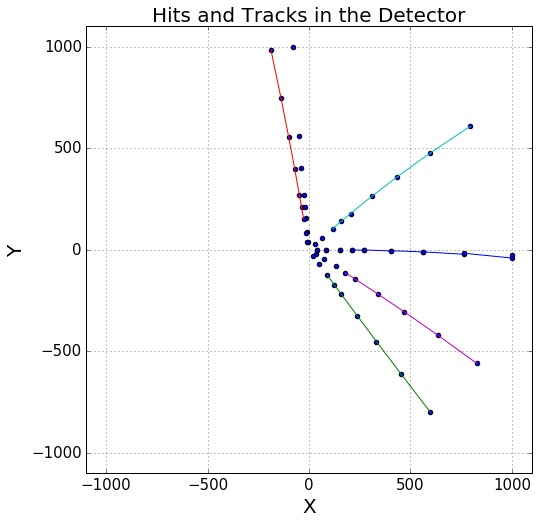

In [7]:
plt.figure(figsize=(8,8))
plt.scatter(X_event[:, 3], X_event[:, 4])

for lab in numpy.unique(y_reco[y_reco != -1]):
    
    xs = X_event[y_reco == lab, 3]
    ys = X_event[y_reco == lab, 4]
    
    sort_inds = xs.argsort()
    
    plt.plot(xs[sort_inds], ys[sort_inds])

plt.title("Hits and Tracks in the Detector", size=20)
plt.xlabel("X", size=20)
plt.ylabel("Y", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlim(-1100, 1100)
plt.ylim(-1100, 1100)
plt.grid(b=1)
plt.show()

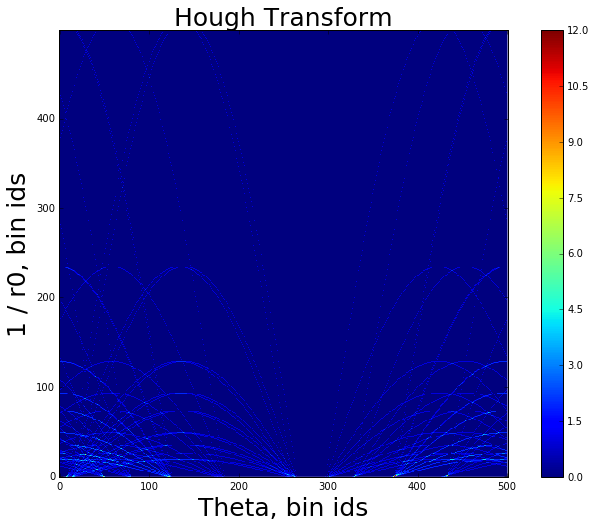

In [8]:
plt.figure(figsize=(12,8))
plt.imshow(matrix_hough.T, interpolation='none', origin='lower')
plt.title("Hough Transform", size=25)
plt.xlabel("Theta, bin ids", size=25)
plt.ylabel("1 / r0, bin ids", size=25)
plt.colorbar()
plt.show()

In [9]:
print "List of tracks. A track is a list of hit indexes. One hit can belong to several recognized tracks."
track_inds

List of tracks. A track is a list of hit indexes. One hit can belong to several recognized tracks.


array([array([12, 23, 39, 49, 50, 54]),
       array([ 9, 12, 16, 24, 45, 46, 60]),
       array([ 0,  5, 15, 23, 36, 54]), array([ 0,  2,  5, 15, 23, 54]),
       array([ 2,  5, 15, 18, 37, 53]),
       array([13, 14, 17, 25, 28, 50, 59]),
       array([ 3, 19, 22, 31, 34, 40]),
       array([ 0,  2,  5, 15, 23, 36, 54]),
       array([ 0,  2,  4,  5, 15, 18, 23, 36, 37, 53, 54, 55]),
       array([ 2,  4,  5,  6, 15, 18, 23, 35, 36, 53, 55]),
       array([ 2,  5, 15, 23, 36, 53, 54]),
       array([ 0,  5, 15, 23, 36, 54]), array([11, 27, 29, 30, 39, 51, 52])], dtype=object)

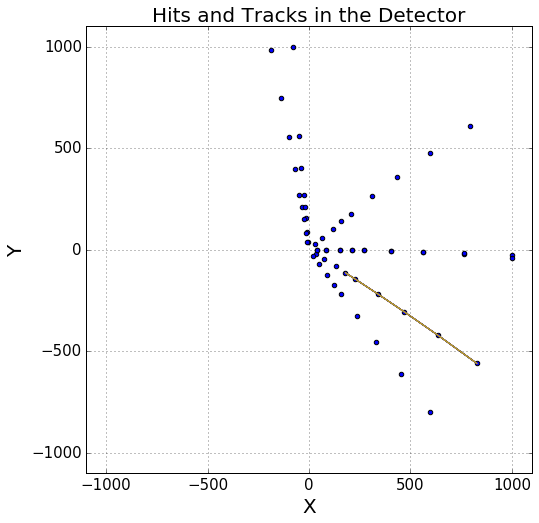

In [10]:
plt.figure(figsize=(8,8))
plt.scatter(X_event[:, 3], X_event[:, 4])

for track in track_inds:
    
    xs = X_event[y_reco == lab, 3]
    ys = X_event[y_reco == lab, 4]
    
    sort_inds = xs.argsort()
    
    plt.plot(xs[sort_inds], ys[sort_inds])

plt.title("Hits and Tracks in the Detector", size=20)
plt.xlabel("X", size=20)
plt.ylabel("Y", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlim(-1100, 1100)
plt.ylim(-1100, 1100)
plt.grid(b=1)
plt.show()

In [11]:
track_params

array([[  3.65155058e-01,   2.50501002e-03],
       [  6.16986132e-01,   1.00200401e-04],
       [  1.52357800e+00,   1.00200401e-04],
       [  1.53616955e+00,   1.00200401e-04],
       [  1.54876111e+00,   1.00200401e-04],
       [  3.31157863e+00,   1.00200401e-04],
       [  4.15521273e+00,   1.00200401e-04],
       [  4.69664954e+00,   1.00200401e-04],
       [  4.70924109e+00,   1.00200401e-04],
       [  4.72183265e+00,   2.00400802e-04],
       [  4.73442420e+00,   2.00400802e-04],
       [  4.74701575e+00,   2.00400802e-04],
       [  5.45214276e+00,   2.00400802e-04]])

## Several events

In [12]:
from hough import Clusterer

ctr = Clusterer(n_theta_bins=5000, n_radius_bins=1000, min_radius=20., min_hits=4)
ctr.fit(X_train, y_train)

In [13]:
%%time
from metrics import predictor

y_pred_test = predictor(ctr, X_test, y_test)

CPU times: user 5 s, sys: 190 ms, total: 5.19 s
Wall time: 5.28 s


## Score

In [14]:
score = submission.score_function(y_test, y_pred_test)
score

0.8057564756281617

## Quality metrics

Track recognition quality metrics described below are based on hit matching technique.

**Track Finding Efficiency** (or Track Efficiency) of a track is defined as:

$$
\epsilon = \frac{N_{reco\_true\_hits}}{N_{reco\_hits}}
$$

where:
* $N_{reco\_true\_hits}$ : is the number of recognized tru hits of the track.
* $N_{reco\_hits}$ : is the number of recognized hits of the track.

The track is considered to be reconstructed if its efficiency is higher than threshold, for example, 80%.

**Reconstruction Efficiency** of an event is defined as:

$$
\epsilon = \frac{N_{reco\_tracks}}{N_{tracks}}
$$

where:
* $N_{reco\_tracks}$ : is number of recognized tracks (without clones) of the event.
* $N_{tracks}$ : is total number of tracks in the event.

**Ghost Rate** is defined as:

$$
\epsilon = \frac{N_{ghost\_tracks}}{N_{tracks}}
$$

where:
* $N_{ghost\_tracks}$ : is number of ghost tracks which do not reconstruct any true particle.
* $N_{tracks}$ : is total number of tracks in the event.


A track recognition method can recognize track of a particle multiple times. Such redundant reconstructions are called clones.

**Clone Rate** is defined as:

$$
\epsilon = \frac{\sum_{m} N_{m\_track}^{clones}}{N_{tracks}}
$$

where:
* $N_{m\_track}^{clones}$ : is number of redundant reconstructions of the m-th track.
* $N_{tracks}$ : is total number of tracks in the event.

In [15]:
from metrics import RecognitionQuality

rq = RecognitionQuality(track_eff_threshold=0.8, min_hits_per_track=4)
report_event, report_tracks = rq.calculate(y_test, y_pred_test)

In [16]:
report_event.head()

,Event,ReconstructionEfficiency,GhostRate,CloneRate,AvgTrackEfficiency
0,3,0.714286,0.142857,0,0.939394
1,16,0.875000,0.125000,0,0.932986
2,18,1.000000,0.000000,0,1.000000
3,26,0.857143,0.000000,0,1.000000
4,37,1.000000,0.000000,0,1.000000


In [17]:
report_event.mean(axis=0)[1:]

ReconstructionEfficiency    0.915898
GhostRate                   0.037872
CloneRate                   0.000000
AvgTrackEfficiency          0.973302
dtype: float64

In [18]:
report_tracks.head()

,Event,Track,TrackEfficiency
0,3,0,0.636364
1,3,1,1.000000
2,3,2,1.000000
3,3,3,1.000000
4,3,4,1.000000
